# Predicting the Sale Price of Bulldozers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of similar bulldozers prices?

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

The goal is therefore to minimize this error

# Data

The data is from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

The link contains everything necessary: the train, test, validation data as well as the feature dictionary

In [3]:
data = pd.read_csv('data/TrainAndValid.csv', low_memory=False)

In [4]:
data.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

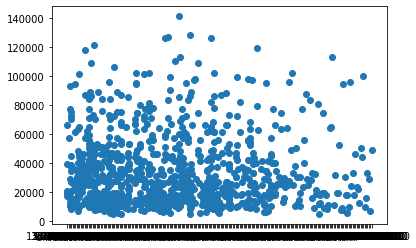

In [6]:
fig, ax = plt.subplots()
ax.scatter(data['saledate'][:1000], data['SalePrice'][:1000])

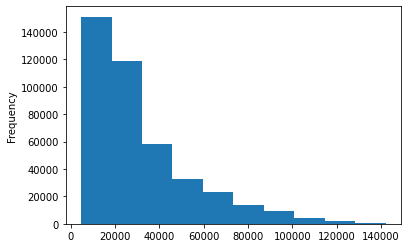

In [7]:
data['SalePrice'].plot.hist();

### Parsing Dates

When we work with time series data, we want to enrich the time & date component as much as possible.

In [5]:
data['saledate'].dtype

dtype('O')

In [6]:
data = pd.read_csv('data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

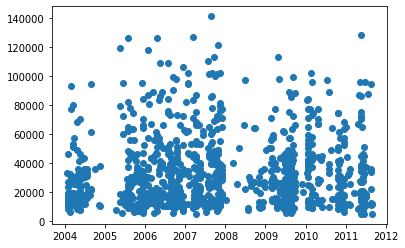

In [13]:
fig, ax = plt.subplots()
ax.scatter(data['saledate'][:1000], data['SalePrice'][:1000])

In [7]:
# Sort by saledate
data.sort_values(by=['saledate'], inplace=True, ascending=True)

In [8]:
data['saledate'].head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

In [9]:
# Create a copy so that we will have the original data
data_copy = data.copy()

### Feature Engineering

Enrich data with new engineered features

In [10]:
data_copy["saleYear"] = data_copy.saledate.dt.year
data_copy["saleMonth"] = data_copy.saledate.dt.month
data_copy["saleDay"] = data_copy.saledate.dt.day
data_copy["saleDayOfWeek"] = data_copy.saledate.dt.dayofweek
data_copy["saleDayOfYear"] = data_copy.saledate.dt.dayofyear

In [20]:
# Pandas doesn't show all columns if there are many - this makes it possible
data_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [11]:
data_copy.drop('saledate', axis=1, inplace=True)

### Convert Strings to Categories

A way to convery string values to numbers is to initally convert them into
categories

In [12]:
# Find the columns which contain strings
for label, content in data_copy.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [13]:
for label, content in data_copy.items():
    if pd.api.types.is_string_dtype(content):
        data_copy[label] = content.astype('category').cat.as_ordered()

In [14]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [15]:
data_copy['state'].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [16]:
# Category index is assigned to the state value
data_copy['state'].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

### Remove missing data

In [17]:
data_copy.isnull().sum()/len(data_copy)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

*Filling numerical data*

In [18]:
for label, content in data_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [19]:
# Check for which numeric columns have null values
for label, content in data_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


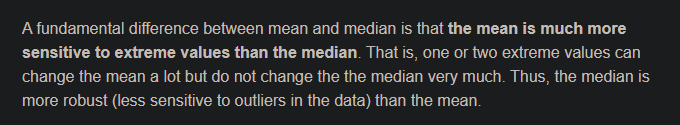

In [20]:
# Fill numeric rows with the median: is more robust than mean
for label, content in data_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            data_copy[label+'_is_missing'] = pd.isnull(content)
            # Fill missing numeric values with median
            data_copy[label] = content.fillna(content.median())

In [21]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [22]:
data_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,0.0,0.0,0.0,0.0,0.0
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


*Filling categorical values*

In [23]:
# Turn categorical variables into numbers and fill missing
for label, content in data_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        data_copy[label+'_is_missing'] = pd.isnull(content)
        # Turn categories into numbers and add 1 (since pandas encodes missing categories as -1)
        data_copy[label] = pd.Categorical(content).codes + 1

In [24]:
data_copy.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [25]:
data_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


# Modelling

### Splitting Data

In [26]:
# According to the details in the competition - the validation data
# starts from year 2012

data_val = data_copy[data_copy.saleYear == 2012]
data_train = data_copy[data_copy.saleYear != 2012]

len(data_val), len(data_train)

(11573, 401125)

In [31]:
# Split data into X & y
X_train, y_train = data_train.drop('SalePrice', axis=1), data_train.SalePrice
X_valid, y_valid = data_val.drop('SalePrice', axis=1), data_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Create an Evaluation helper function

In [29]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_valid, val_preds),
        'Training RMSLE': rmsle(y_train, train_preds),
        'Valid RMSLE': rmsle(y_valid, val_preds),
        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_valid, val_preds)
    }

    return scores

### Fit model

In [33]:
# Takes far too long for experimenting
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs=-1, random_state=42)
# model.fit(X_train, y_train)

### Fit model in a subset of data (to tune the hyperparameters)

Decreases the amount of time for experimenting

In [34]:
model = RandomForestRegressor(
    n_jobs=-1,
    random_state=42,    # for reproducible results
    max_samples=10000
)

In [35]:
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [36]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Tune hyperparameters using Randomized Search CV

In [37]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'auto'],
    'max_samples': [10000]
}

rs_model = RandomizedSearchCV(
   RandomForestRegressor(n_jobs=-1, random_state=42),
   param_distributions=rf_grid,
   n_iter=2,
   cv=5,
   verbose=True
)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 1min 26s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [38]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 12,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 5}

In [39]:
show_scores(rs_model)

{'Training MAE': 9460.545203704629,
 'Valid MAE': 10582.652167932967,
 'Training RMSLE': 0.4050177118392809,
 'Valid RMSLE': 0.41986216949697786,
 'Training R^2': 0.6380142193806193,
 'Valid R^2': 0.6589702926897629}

### Train model with best hyperparameters

These were found after 100 `n_iters` of `RandomizedSearchCV`

In [40]:
%%time

ideal_model = RandomForestRegressor(
    n_estimators = 40,
    min_samples_leaf = 1,
    min_samples_split = 14,
    max_features = 0.5,
    n_jobs = -1,
    max_samples = None,
    random_state = 42
)

ideal_model.fit(X_train, y_train)

Wall time: 1min 10s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [41]:
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

# Make Predictions

In [43]:
data_test = pd.read_csv(
    'data/Test.csv',
    low_memory=False,
    parse_dates=['saledate']
)

data_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocess test data

In [47]:
def preprocess_data(df):
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    
    df.drop('saledate', axis=1, inplace=True)
    
    for label, content in df.items():
        # Fill the numeric rows with median
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+'_is_missing'] = pd.isnull(content)
                df[label] = content.fillna(content.median())
    
        # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+'_is_missing'] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1
    
    return df

In [48]:
# Process the test data 
data_test = preprocess_data(data_test)
data_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [56]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


A column seems to be missing 🤔

In [58]:
set(X_train.columns) - set(data_test.columns)

{'auctioneerID_is_missing'}

In [68]:
data_test['auctioneerID'].isnull().value_counts()

False    12457
Name: auctioneerID, dtype: int64

In [69]:
# Since this column has no empty data - the '_missing' column was not added
# Hence, add it manually
data_test['auctioneerID_is_missing'] = False
data_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [72]:
set(X_train.columns) - set(data_test.columns)

set()

### Predict on test data

In [70]:
test_preds = ideal_model.predict(data_test)

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [71]:
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

### Format predictions to what Kaggle requires

https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [73]:
df_preds = pd.DataFrame()
df_preds['SalesID'] = data_test['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


### Save predictions

In [74]:
df_preds.to_csv("data/test_predictions.csv", index=False)

# Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).

In [75]:
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [85]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    ordered_df = (
        pd.DataFrame({
            'features': columns,
            'feature_importances': importances
        }).sort_values('feature_importances', ascending=False)
        .reset_index(drop=True)
    )
    
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Get only the top n features
    ax.barh(ordered_df['features'][:n], ordered_df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

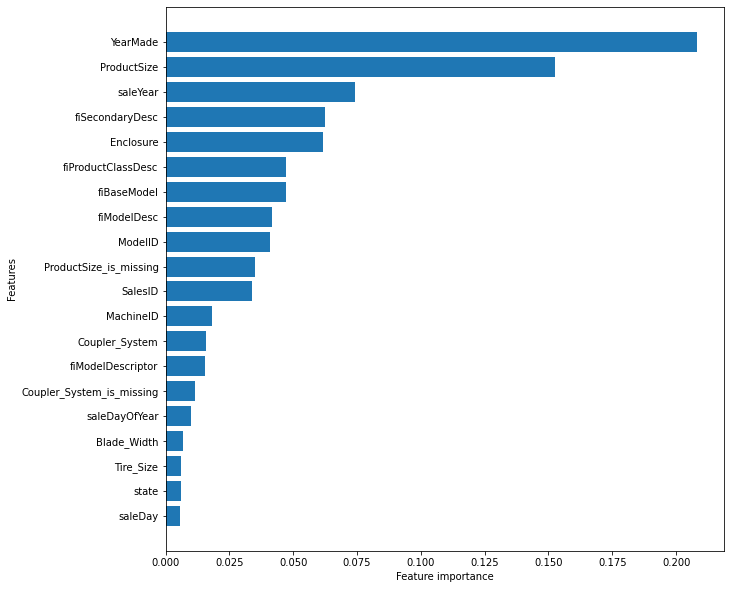

In [86]:
plot_features(X_train.columns, ideal_model.feature_importances_)

*Using this we could drop features that have little-to-no effect on the target variable*